In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import numpy as np
import h5py
from tqdm.auto import tqdm, trange
import scipy.io
import time
import torch
import random
import math
import shutil
from sklearn.decomposition import PCA
import scipy as sp
import scipy.signal
import os
import pandas as pd

from analysis.proj import learn_manifold_umap, pca_train, pca
from analysis.plotting import plot_all_pts, plot_contr_v_pca, plot_recon_v_spike, plot_spike_loc_classes
from analysis.contrastive_utils import get_enc_backbone, get_fcenc_backbone, get_ckpt_results
from analysis.cluster import GMM, HDBSCAN
from analysis.benchmarking import class_scores, avg_score, per_class_accs, avg_class_accs

In [3]:
import matplotlib.pyplot as plt
# %matplotlib inline
plt.rc("figure", dpi=100)
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)
plt.rc('axes', labelsize=SMALL_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

## Load Data

In [4]:
import MEArec as mr
base_path = Path('/media/cat/cole/')

rec_path = base_path / 'mearec_sim/recordings_80cells_Neuropixels2-64_600.0_10uV_11-04-2023_18-47.h5'

recgen = mr.load_recordings(rec_path, load_waveforms=False)
# recgen.extract_templates(cut_out=[1.9,1.91], recompute=True)
geom = recgen.channel_positions[()]
depth_order = np.argsort(geom[:,2])

In [7]:
mearec_unit_ids = np.load(base_path / 'mearec_sim/unit_ids.npy')
print(mearec_unit_ids.shape)

mearec_wfs_train = np.load(base_path / 'mearec_sim/spikes_train.npy')
mearec_wfs_test = np.load(base_path / 'mearec_sim/spikes_test.npy')
mearec_denoised_wfs_train = np.load(base_path / 'mearec_sim/denoised_spikes_train.npy')
mearec_denoised_wfs_test = np.load(base_path / 'mearec_sim/denoised_spikes_test.npy')

mearec_wfs_train_locs = np.load(base_path / 'mearec_sim/spikes_train_locs.npy')
mearec_wfs_test_locs = np.load(base_path / 'mearec_sim/spikes_test_locs.npy')
mearec_denoised_wfs_train_locs = np.load(base_path / 'mearec_sim/denoised_spikes_train_locs.npy')
mearec_denoised_wfs_test_locs = np.load(base_path / 'mearec_sim/denoised_spikes_test_locs.npy')

mearec_flat_train = pca(np.array([mc.flatten() for mc in mearec_wfs_train]), 2)[0]
mearec_flat_test = pca(np.array([mc.flatten() for mc in mearec_wfs_test]), 2)[0]
denoised_mearec_flat_train = pca(np.array([mc.flatten() for mc in mearec_denoised_wfs_train]), 2)[0]
denoised_mearec_flat_test = pca(np.array([mc.flatten() for mc in mearec_denoised_wfs_test]), 2)[0]
mearec_flat_train_4pc = pca(np.array([mc.flatten() for mc in mearec_wfs_train]), 4)[0]
mearec_flat_test_4pc = pca(np.array([mc.flatten() for mc in mearec_wfs_test]), 4)[0]

# plot_locs = mearec_wfs_test_locs
cluster_method = 'HDBSCAN'
models = ['{} Multi-Chan feat=(x_loc, z_loc, PC1, PC2)'.format(cluster_method), '{} Multi-Chan Denoised feat=(x_loc, z_loc, PC1, PC2)'.format(cluster_method), 
          '{} Multi-Chan feat=(PC1, PC2, PC3, PC4)'.format(cluster_method)] 

_, pred_labels_0 = avg_score(mearec_flat_train, mearec_flat_test, 13, layers=[1000, 100, 13], epochs=100, mod_type=cluster_method.lower(), ret_pred_labels=True)
_, pred_labels_1 = avg_score(denoised_mearec_flat_train, denoised_mearec_flat_test, 13, layers=[1000, 100, 13], epochs=100, mod_type=cluster_method.lower(), ret_pred_labels=True)
_, pred_labels_2 = avg_score(mearec_flat_train_4pc, mearec_flat_test_4pc, 13, layers=[1000, 100, 13], epochs=100, mod_type=cluster_method.lower(), ret_pred_labels=True)

(13,)


(3900,)
(3900,)
(3900,)


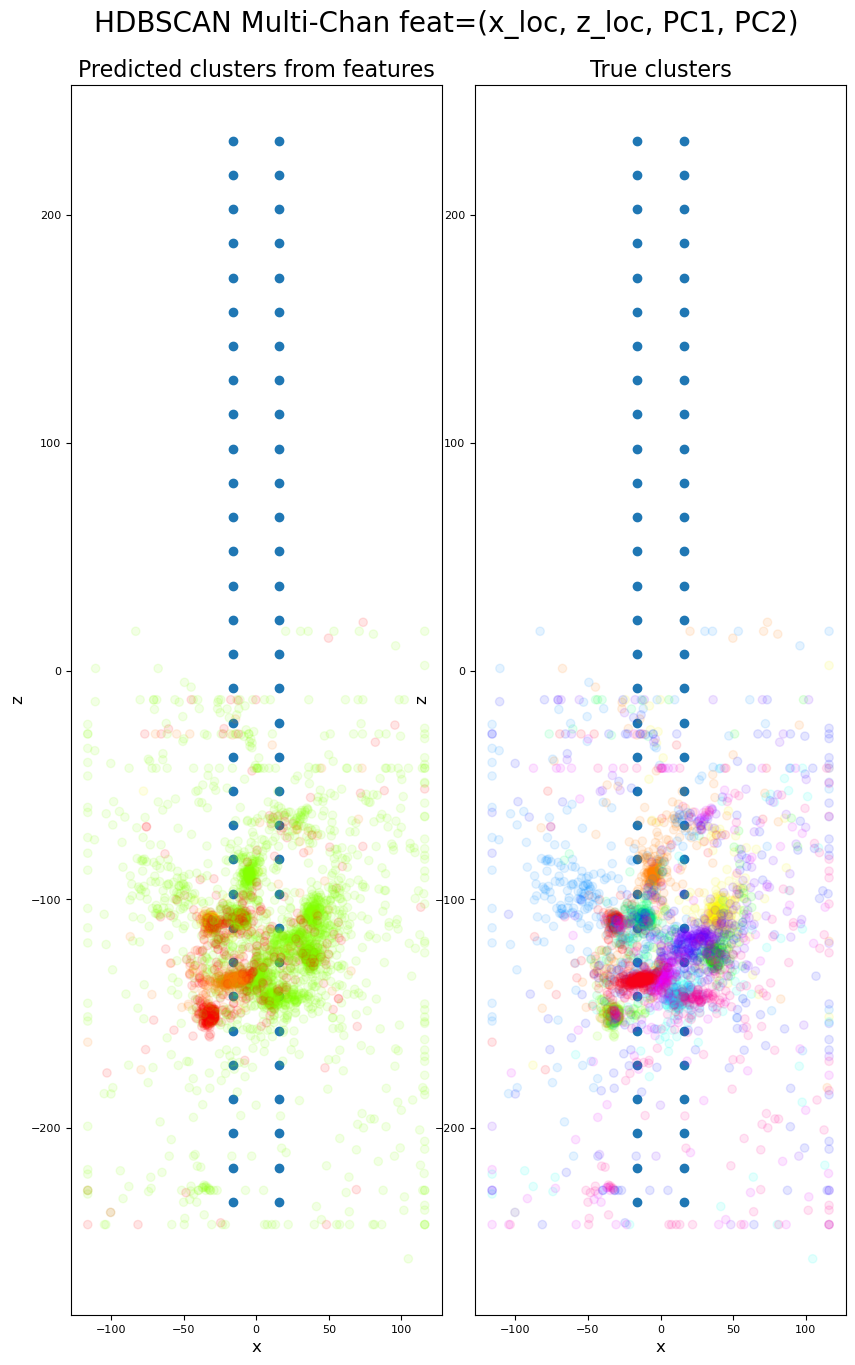

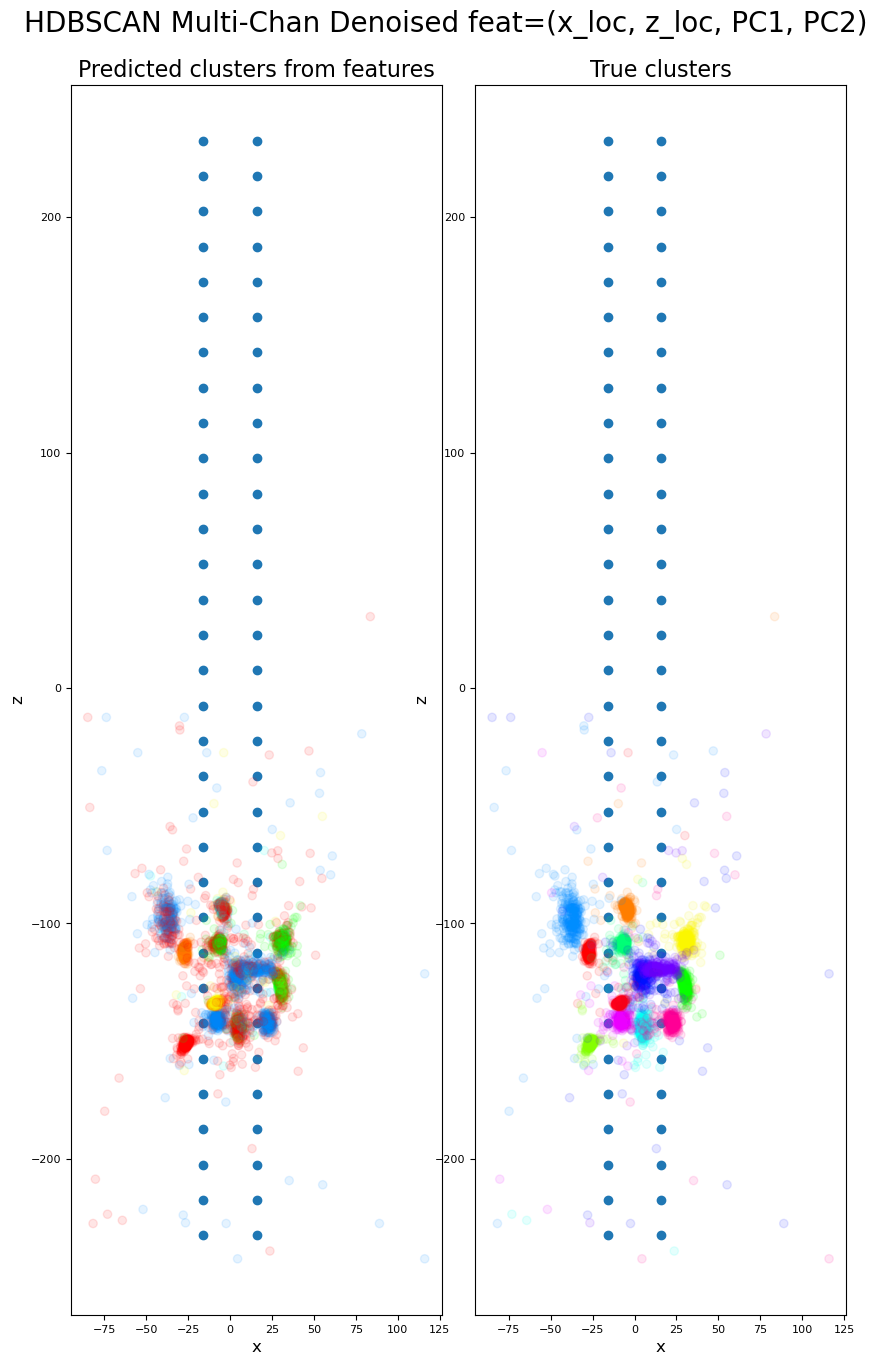

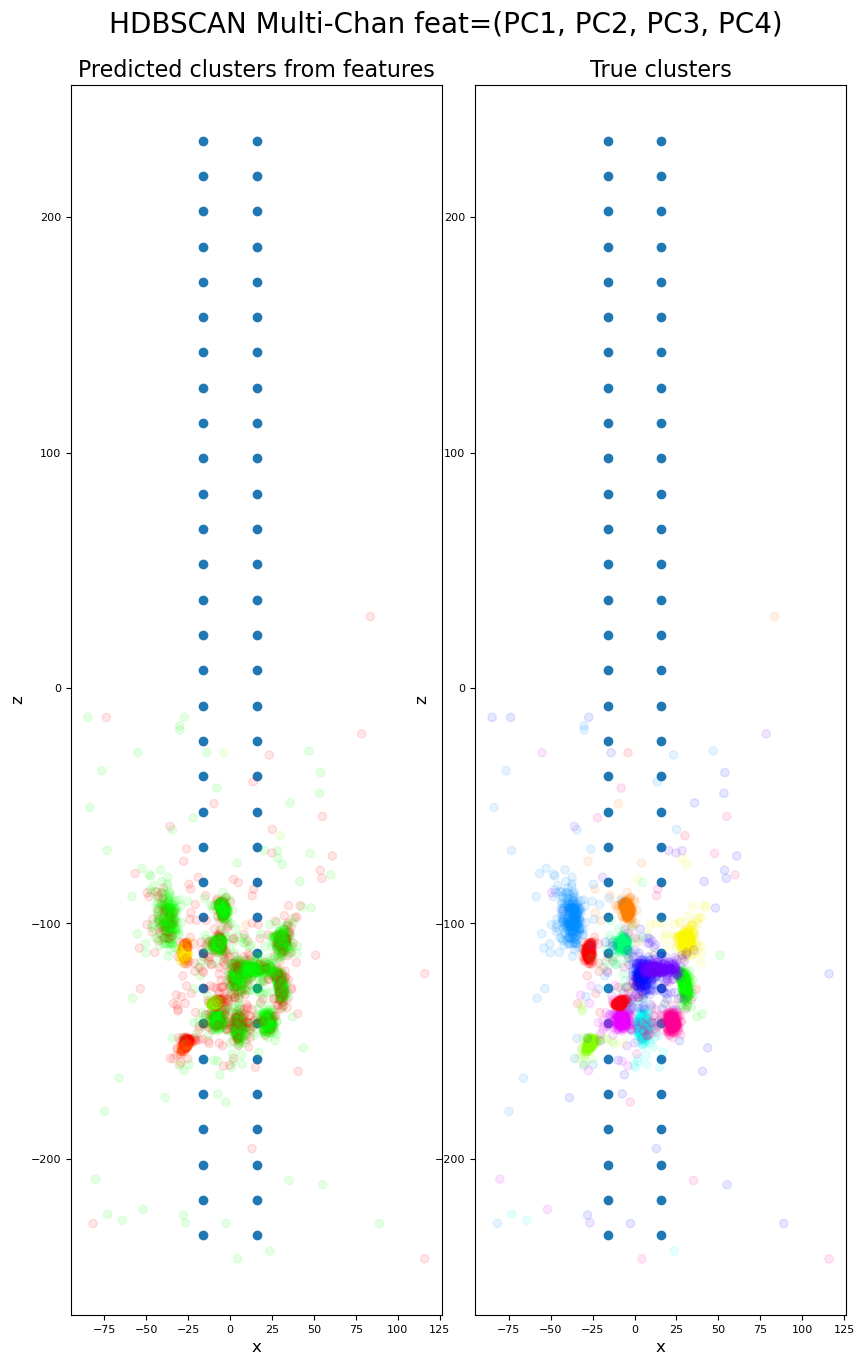

In [8]:
plot_spike_loc_classes(mearec_wfs_test_locs, pred_labels_0, 13, geom, models[0], '{}_loc+2dpca_featplot'.format(cluster_method.lower()))
plot_spike_loc_classes(mearec_denoised_wfs_test_locs, pred_labels_1, 13, geom, models[1], '{}_den_loc+2dpca_featplot'.format(cluster_method.lower()))
plot_spike_loc_classes(mearec_denoised_wfs_test_locs, pred_labels_2, 13, geom, models[2], '{}_4dpca_featplot'.format(cluster_method.lower()))

In [9]:
train_list = []
test_list = []

std_scale = 0.001

mearec_flat_train = pca(np.array([mc.flatten() for mc in mearec_wfs_train])
                        - np.mean(np.array([mc.flatten() for mc in mearec_wfs_train]), axis=0), 2)[0] * std_scale
mearec_flat_test = pca_train(np.array([mc.flatten() for mc in mearec_wfs_train])
                        - np.mean(np.array([mc.flatten() for mc in mearec_wfs_train]), axis=0),
                        np.array([mc.flatten() for mc in mearec_wfs_test])
                        - np.mean(np.array([mc.flatten() for mc in mearec_wfs_test]), axis=0), 2)[0] * std_scale
denoised_mearec_flat_train = pca(np.array([mc.flatten() for mc in mearec_denoised_wfs_train])
                        - np.mean(np.array([mc.flatten() for mc in mearec_denoised_wfs_train]), axis=0), 2)[0] * std_scale
denoised_mearec_flat_test = pca_train(np.array([mc.flatten() for mc in mearec_denoised_wfs_train])
                        - np.mean(np.array([mc.flatten() for mc in mearec_denoised_wfs_train])),
                        np.array([mc.flatten() for mc in mearec_denoised_wfs_test])
                        - np.mean(np.array([mc.flatten() for mc in mearec_denoised_wfs_test]), axis=0), 2)[0] * std_scale
mearec_flat_train_4pc = pca(np.array([mc.flatten() for mc in mearec_wfs_train])
                        - np.mean(np.array([mc.flatten() for mc in mearec_wfs_train]), axis=0), 4)[0] * std_scale
mearec_flat_test_4pc = pca_train(np.array([mc.flatten() for mc in mearec_wfs_train])
                        - np.mean(np.array([mc.flatten() for mc in mearec_wfs_train]), axis=0),
                        np.array([mc.flatten() for mc in mearec_wfs_test])
                        - np.mean(np.array([mc.flatten() for mc in mearec_wfs_test]), axis=0), 4)[0] * std_scale

wfs_train = np.concatenate((mearec_wfs_train_locs, mearec_flat_train), axis=1).reshape(-1, 4)
wfs_test = np.concatenate((mearec_wfs_test_locs, mearec_flat_test), axis=1).reshape(-1, 4)

wfs_train_4pc = mearec_flat_train_4pc.reshape(-1, 4)
wfs_test_4pc = mearec_flat_test_4pc.reshape(-1, 4)

denoised_wfs_train = np.concatenate((mearec_denoised_wfs_train_locs, denoised_mearec_flat_train), axis=1).reshape(-1, 4)
denoised_wfs_test = np.concatenate((mearec_denoised_wfs_test_locs, denoised_mearec_flat_test), axis=1).reshape(-1, 4)

train_list.append(wfs_train)
train_list.append(denoised_wfs_train)
train_list.append(wfs_train_4pc)
train_list.append(mearec_wfs_train_locs)
train_list.append(mearec_denoised_wfs_train_locs)
test_list.append(wfs_test)
test_list.append(denoised_wfs_test)
test_list.append(wfs_test_4pc)
test_list.append(mearec_wfs_test_locs)
test_list.append(mearec_denoised_wfs_test_locs)

cluster_method = 'GMM'
models = ['{} Multi-Chan (x_loc, z_loc, PC1, PC2)'.format(cluster_method), '{} Multi-Chan Denoised (x_loc, z_loc, PC1, PC2)'.format(cluster_method), 
          '{} Multi-Chan (PC1, PC2, PC3, PC4)'.format(cluster_method), '{} Multi-Chan (x_loc, z_loc)'.format(cluster_method), 
          '{} Multi-Chan Denoised (x_loc, z_loc)'.format(cluster_method)] 
#           'Multi-Chan Transformer 5D (lr=0.001)', 'Multi-Chan Transformer 5D (lr=0.01)']

per_class_map = per_class_accs(train_list, test_list, models, 13, cluster_method.lower(), mearec_unit_ids)
avg_class_map = avg_class_accs(train_list, test_list, models, 13, cluster_method.lower())

pc_df = pd.DataFrame.from_dict(per_class_map, 'index')
ac_df = pd.DataFrame.from_dict(avg_class_map)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(pc_df)
    
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(ac_df)

train done
pca test done
train done
pca test done
train done
pca test done


wf #0  wf #4  wf #5  wf #17  \
GMM Multi-Chan (x_loc, z_loc, PC1, PC2)             0.0    0.0    0.0     0.0   
GMM Multi-Chan Denoised (x_loc, z_loc, PC1, PC2)    0.0    0.0    0.0     0.0   
GMM Multi-Chan (PC1, PC2, PC3, PC4)               100.0  100.0    0.0     0.0   
GMM Multi-Chan (x_loc, z_loc)                       0.0    0.0    0.0     0.0   
GMM Multi-Chan Denoised (x_loc, z_loc)              0.0    0.0    0.0     0.0   

                                                  wf #24  wf #32  wf #34  \
GMM Multi-Chan (x_loc, z_loc, PC1, PC2)              0.0     0.0     0.0   
GMM Multi-Chan Denoised (x_loc, z_loc, PC1, PC2)     0.0     0.0     0.0   
GMM Multi-Chan (PC1, PC2, PC3, PC4)                  0.0     0.0     0.0   
GMM Multi-Chan (x_loc, z_loc)                        0.0     0.0     0.0   
GMM Multi-Chan Denoised (x_loc, z_loc)               0.0     0.0     0.0   

                                                  wf #36  wf #40  wf #45  \
GMM Multi-Chan (x_loc, z_loc, PC1, PC2)              0.0     0.0     0.0   
GMM Multi-Chan Denoised (x_loc, z_loc, PC1, PC2)     0.0     0.0     0.0   
GMM Multi-Chan (PC1, PC2, PC3, PC4)                100.0     0.0     0.0   
GMM Multi-Chan (x_loc, z_loc)                        0.0     0.0     0.0   
GMM Multi-Chan Denoised (x_loc, z_loc)               0.0     0.0     0.0   

                                                  wf #52  wf #62  wf #72  
GMM Multi-Chan (x_loc, z_loc, PC1, PC2)              0.0     0.0     0.0  
GMM Multi-Chan Denoised (x_loc, z_loc, PC1, PC2)     0.0     0.0     0.0  
GMM Multi-Chan (PC1, PC2, PC3, PC4)                  0.0     0.0     0.0  
GMM Multi-Chan (x_loc, z_loc)                        0.0     0.0     0.0  
GMM Multi-Chan Denoised (x_loc, z_loc)               0.0     0.0     0.0

GMM Multi-Chan (x_loc, z_loc, PC1, PC2)  \
score                                31.510293   

       GMM Multi-Chan Denoised (x_loc, z_loc, PC1, PC2)  \
score                                         72.826441   

       GMM Multi-Chan (PC1, PC2, PC3, PC4)  GMM Multi-Chan (x_loc, z_loc)  \
score                             1.954921                      30.090141   

       GMM Multi-Chan Denoised (x_loc, z_loc)  
score                               72.049176

In [12]:
_, pred_labels_0 = avg_score(mearec_flat_train, mearec_flat_test, 13, layers=[1000, 100, 13], epochs=100, mod_type=cluster_method.lower(), ret_pred_labels=True)
_, pred_labels_1 = avg_score(denoised_mearec_flat_train, denoised_mearec_flat_test, 13, layers=[1000, 100, 13], epochs=100, mod_type=cluster_method.lower(), ret_pred_labels=True)
_, pred_labels_2 = avg_score(mearec_flat_train_4pc, mearec_flat_test_4pc, 13, layers=[1000, 100, 13], epochs=100, mod_type=cluster_method.lower(), ret_pred_labels=True)

In [14]:
models

['GMM Multi-Chan (x_loc, z_loc, PC1, PC2)',
 'GMM Multi-Chan Denoised (x_loc, z_loc, PC1, PC2)',
 'GMM Multi-Chan (PC1, PC2, PC3, PC4)',
 'GMM Multi-Chan (x_loc, z_loc)',
 'GMM Multi-Chan Denoised (x_loc, z_loc)']

(3900,)
(3900,)
(3900,)


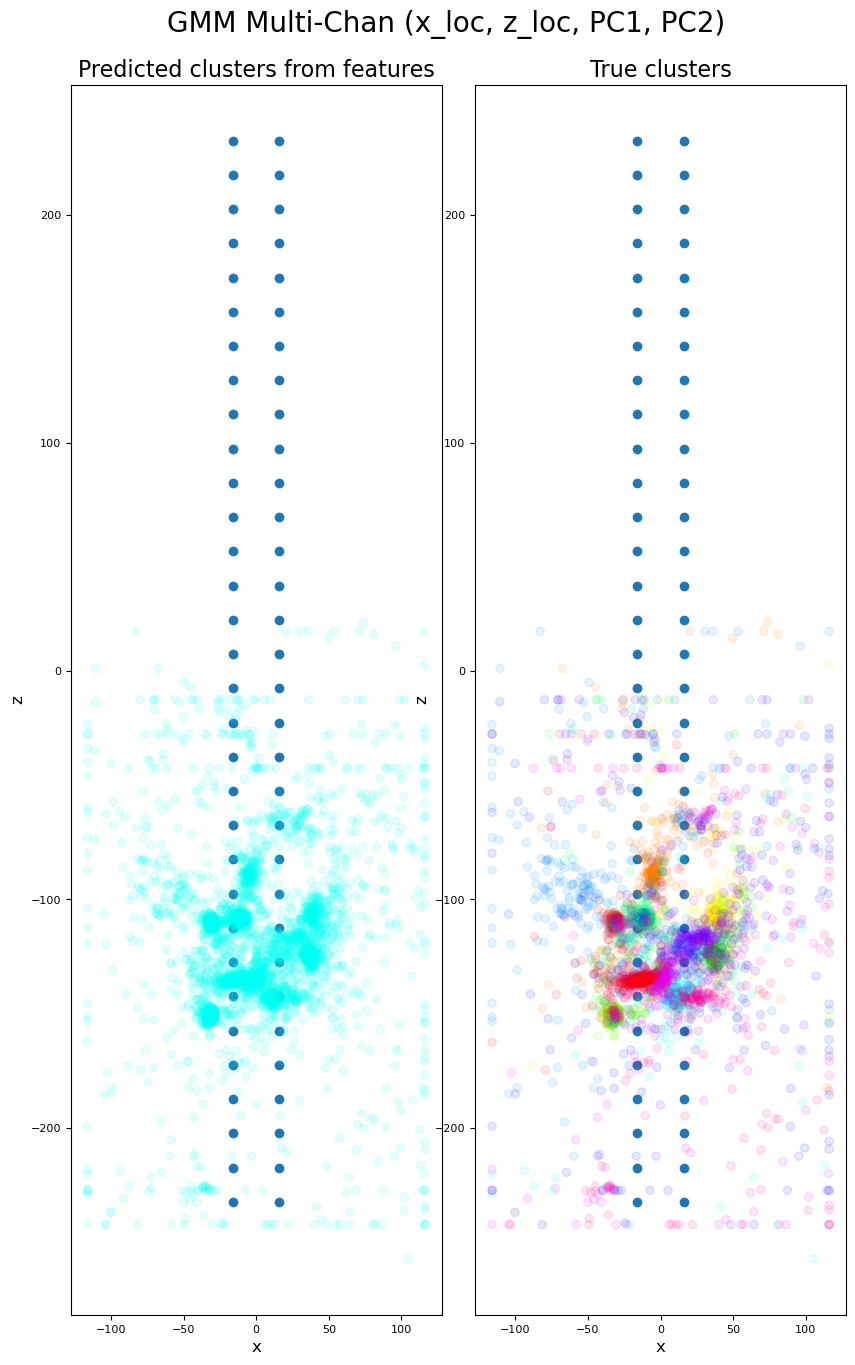

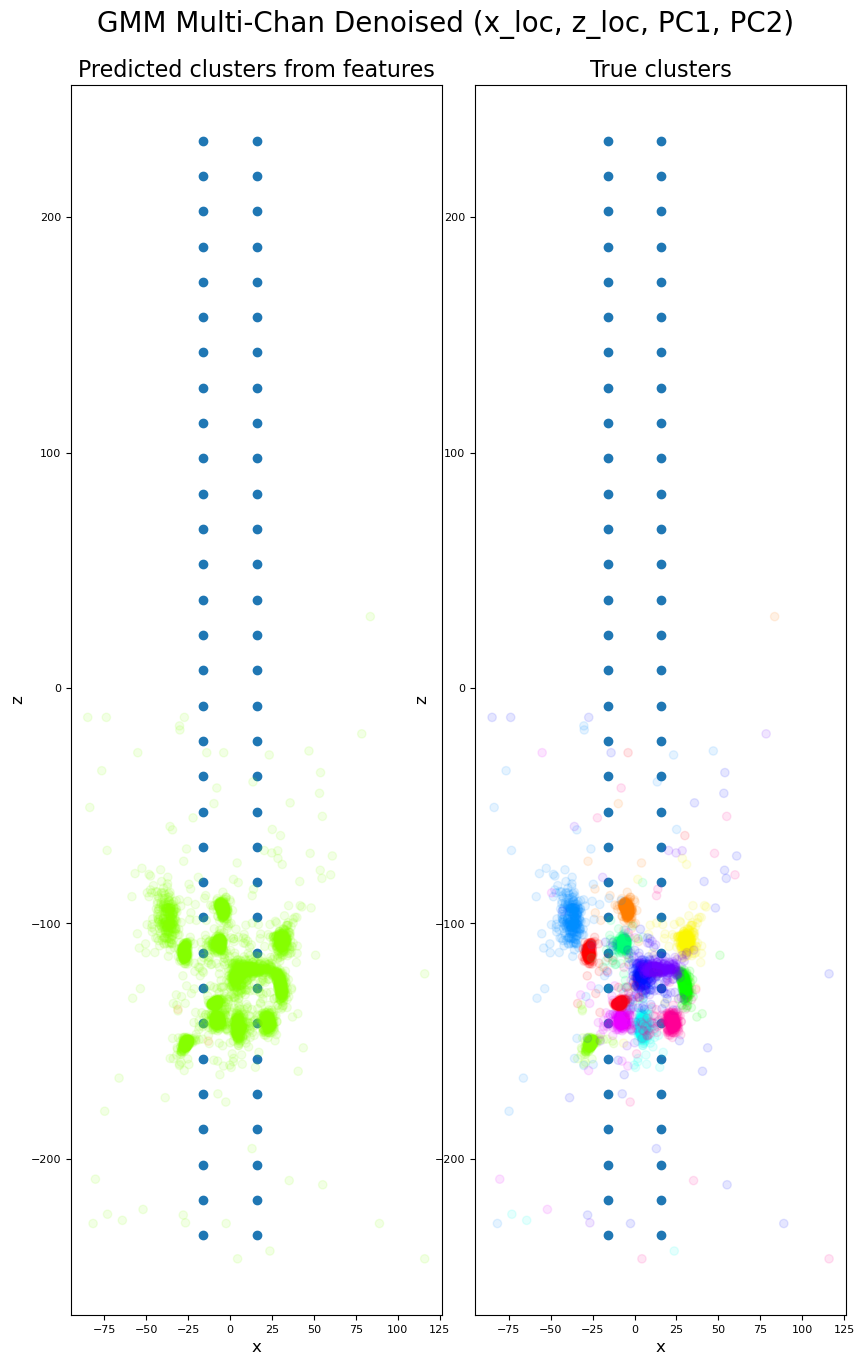

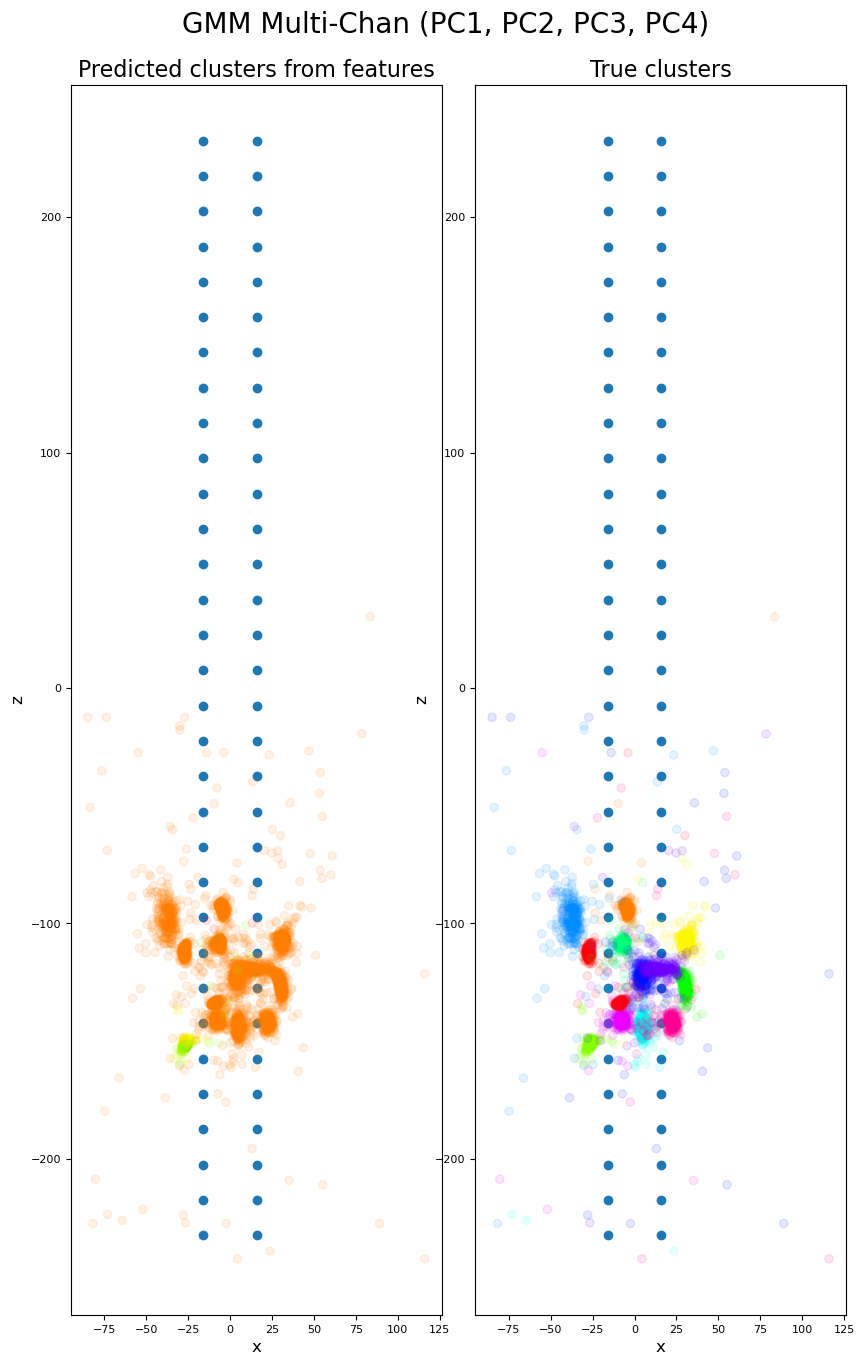

In [17]:
plot_spike_loc_classes(mearec_wfs_test_locs, pred_labels_0, 13, geom, models[0], '{}_loc+2dpca_featplot'.format(cluster_method.lower()))
plot_spike_loc_classes(mearec_denoised_wfs_test_locs, pred_labels_1, 13, geom, models[1], '{}_den_loc+2dpca_featplot'.format(cluster_method.lower()))
plot_spike_loc_classes(mearec_denoised_wfs_test_locs, pred_labels_2, 13, geom, models[2], '{}_4dpca_featplot'.format(cluster_method.lower()))

In [18]:
std_scale = mearec_denoised_wfs_train_locs.std(0).mean()
mearec_flat_test_4pc *= std_scale
denoised_mearec_flat_test *= std_scale

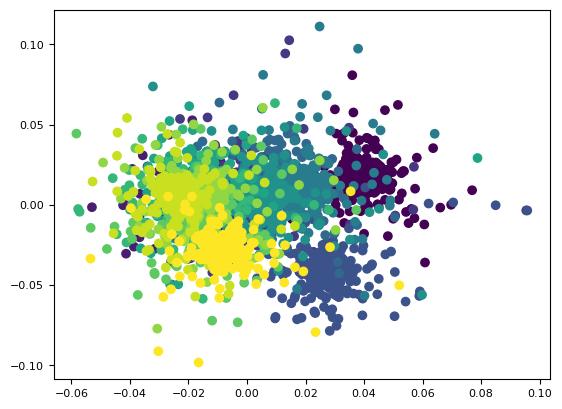

In [19]:
test_labels = [[i for j in range(300)] for i in range(13)]
plt.scatter(mearec_flat_test_4pc[:, 0], mearec_flat_test_4pc[:, 1], c=test_labels)

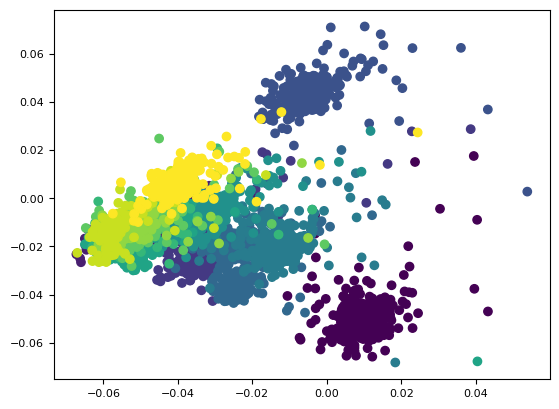

In [20]:
test_labels = [[i for j in range(300)] for i in range(13)]
plt.scatter(denoised_mearec_flat_test[:, 0], denoised_mearec_flat_test[:, 1], c=test_labels)

ValueError: 'c' argument has 3900 elements, which is inconsistent with 'x' and 'y' with size 15600.

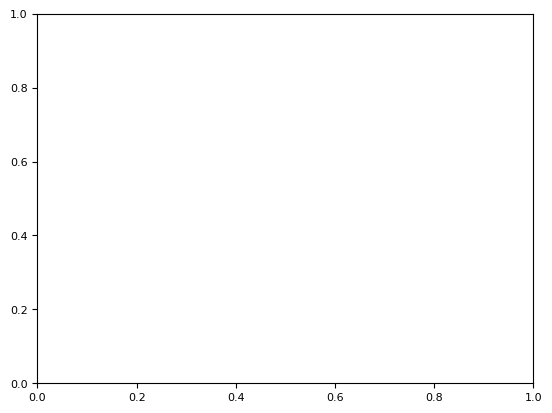

In [21]:
test_labels = [[i for j in range(300)] for i in range(13)]
plt.scatter(mearec_denoised_wfs_train_locs[:, 0], mearec_denoised_wfs_train_locs[:, 1], c=test_labels)

In [ ]:
mearec_denoised_wfs_train_locs.std(0).mean()

In [ ]:
mearec_exp_var = pca(np.array([mc.flatten() for mc in mearec_wfs_train]), 4)[1]
print(mearec_exp_var)
print(np.sum(mearec_exp_var))

Using projector; batchnorm False with depth 2
train done
pca test done
300
(3000,)
Using projector; batchnorm False with depth 2
train done
pca test done
300
(3000,)
Using projector; batchnorm False with depth 2
train done
pca test done
300
(3000,)
Using projector; batchnorm False with depth 2
train done
pca test done
300
(3000,)
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.


wf 8       wf 9      wf 11  \
PCA 2D                                            100.0  99.333333  62.666667   
PCA 3D                                            100.0  98.666667  61.000000   
PCA 5D                                            100.0  98.666667  76.333333   
PCA 10D                                           100.0  96.000000  75.333333   
Contrastive 2D (augs=amp/jit/noise, fc encoder)   100.0  97.333333  84.666667   
Contrastive 3D (augs=amp/jit/noise, fc encoder)   100.0  96.333333  94.000000   
Contrastive 5D (augs=amp/jit/noise, fc encoder)   100.0  98.000000  90.666667   
Contrastive 10D (augs=amp/jit/noise, fc encoder)  100.0  98.000000  92.333333   

                                                      wf 33      wf 65  \
PCA 2D                                            82.333333  75.333333   
PCA 3D                                            92.333333  82.000000   
PCA 5D                                            92.000000  86.333333   
PCA 10D                                           93.000000  89.333333   
Contrastive 2D (augs=amp/jit/noise, fc encoder)   91.666667  88.666667   
Contrastive 3D (augs=amp/jit/noise, fc encoder)   95.333333  87.666667   
Contrastive 5D (augs=amp/jit/noise, fc encoder)   93.666667  86.000000   
Contrastive 10D (augs=amp/jit/noise, fc encoder)  94.000000  90.666667   

                                                      wf 69     wf 109  \
PCA 2D                                            49.000000  62.000000   
PCA 3D                                            46.666667  60.333333   
PCA 5D                                            43.000000  55.000000   
PCA 10D                                           53.000000  37.333333   
Contrastive 2D (augs=amp/jit/noise, fc encoder)   51.333333  19.666667   
Contrastive 3D (augs=amp/jit/noise, fc encoder)   44.666667  39.000000   
Contrastive 5D (augs=amp/jit/noise, fc encoder)   48.000000  38.666667   
Contrastive 10D (augs=amp/jit/noise, fc encoder)  47.333333  33.000000   

                                                      wf 13     wf 329  \
PCA 2D                                            88.666667  17.666667   
PCA 3D                                            93.000000  24.333333   
PCA 5D                                            92.000000  49.333333   
PCA 10D                                           97.000000  70.000000   
Contrastive 2D (augs=amp/jit/noise, fc encoder)   95.666667  64.666667   
Contrastive 3D (augs=amp/jit/noise, fc encoder)   96.000000  57.000000   
Contrastive 5D (augs=amp/jit/noise, fc encoder)   93.666667  64.666667   
Contrastive 10D (augs=amp/jit/noise, fc encoder)  94.666667  74.333333   

                                                     wf 151  
PCA 2D                                            63.000000  
PCA 3D                                            67.333333  
PCA 5D                                            79.000000  
PCA 10D                                           88.333333  
Contrastive 2D (augs=amp/jit/noise, fc encoder)   92.333333  
Contrastive 3D (augs=amp/jit/noise, fc encoder)   89.666667  
Contrastive 5D (augs=amp/jit/noise, fc encoder)   94.666667  
Contrastive 10D (augs=amp/jit/noise, fc encoder)  93.333333

PCA 2D     PCA 3D     PCA 5D    PCA 10D  \
score  69.966667  73.066667  76.933333  81.233333   

       Contrastive 2D (augs=amp/jit/noise, fc encoder)  \
score                                        78.433333   

       Contrastive 3D (augs=amp/jit/noise, fc encoder)  \
score                                             79.9   

       Contrastive 5D (augs=amp/jit/noise, fc encoder)  \
score                                        80.966667   

       Contrastive 10D (augs=amp/jit/noise, fc encoder)  
score                                         81.566667

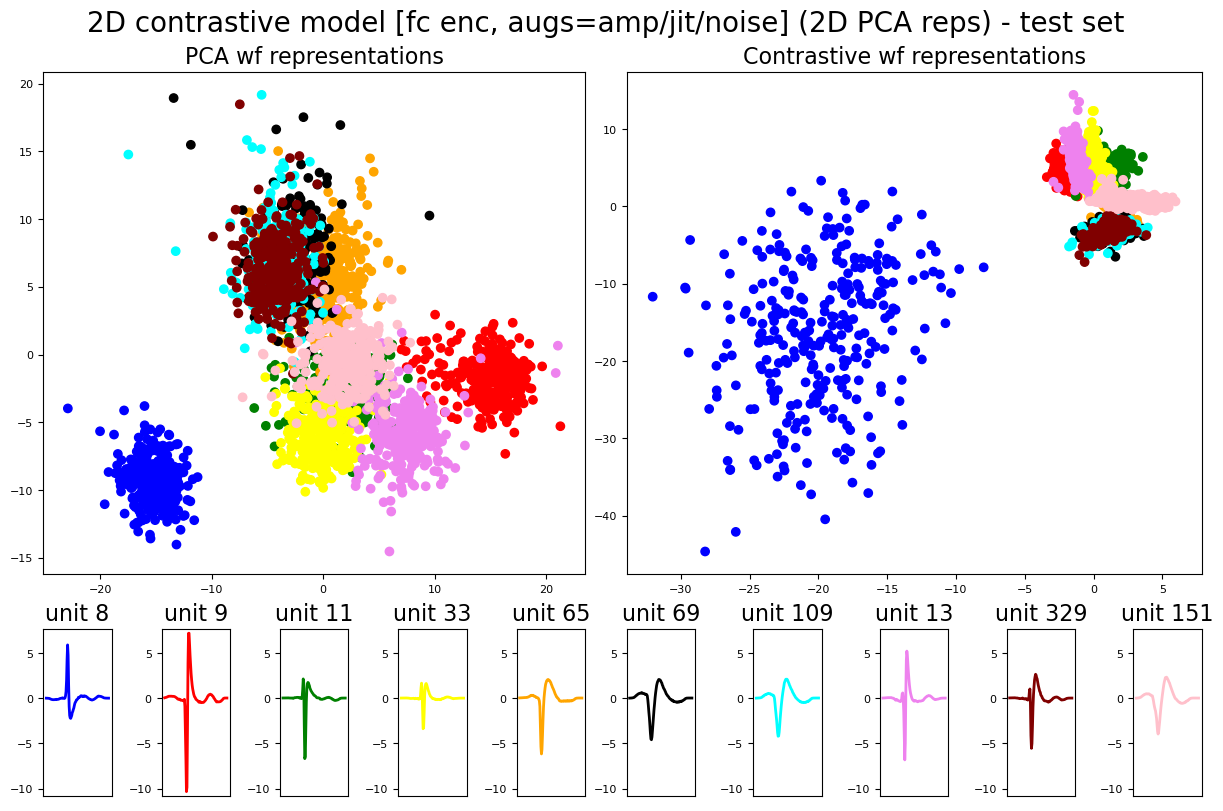

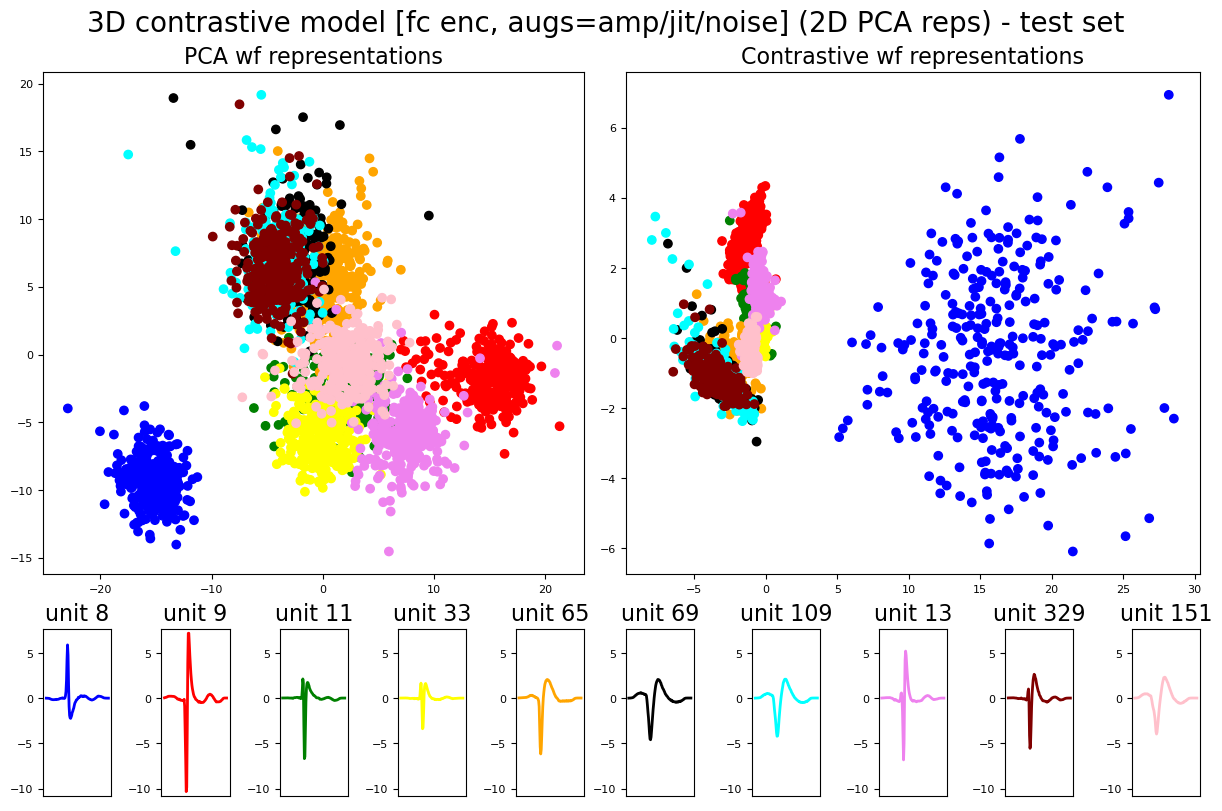

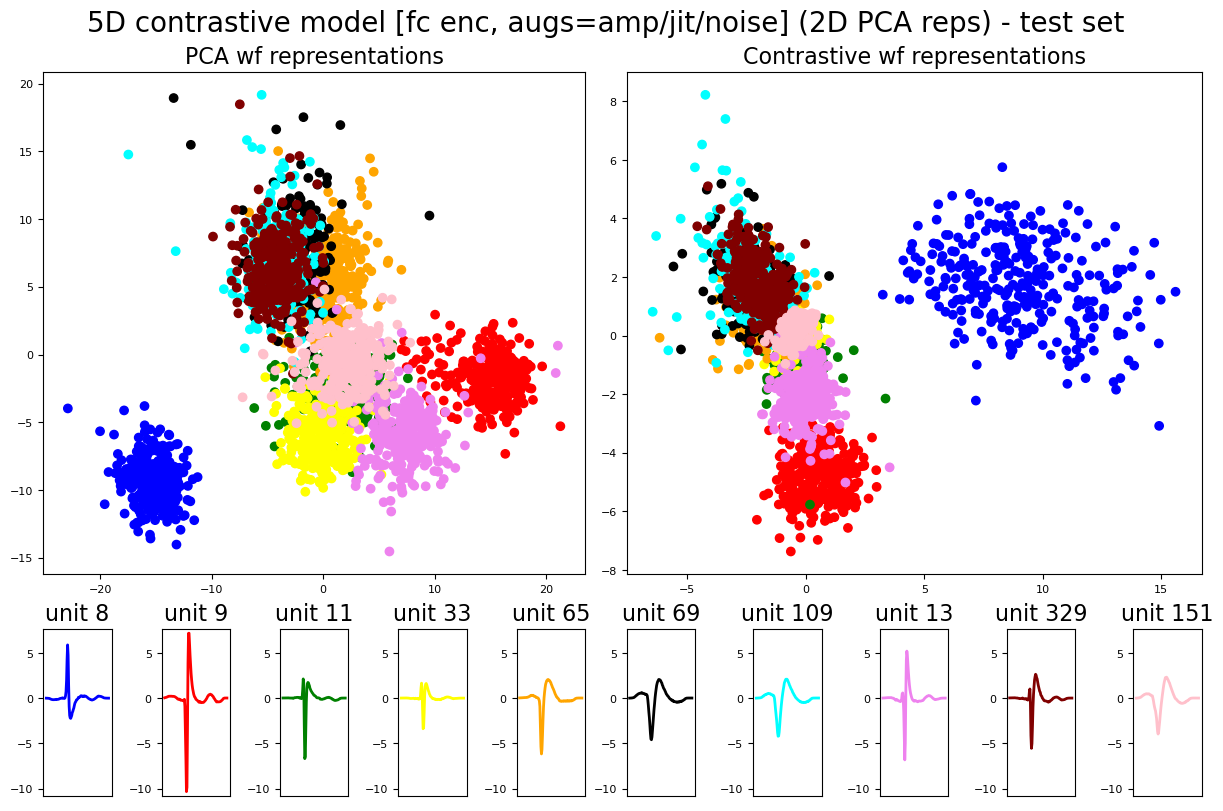

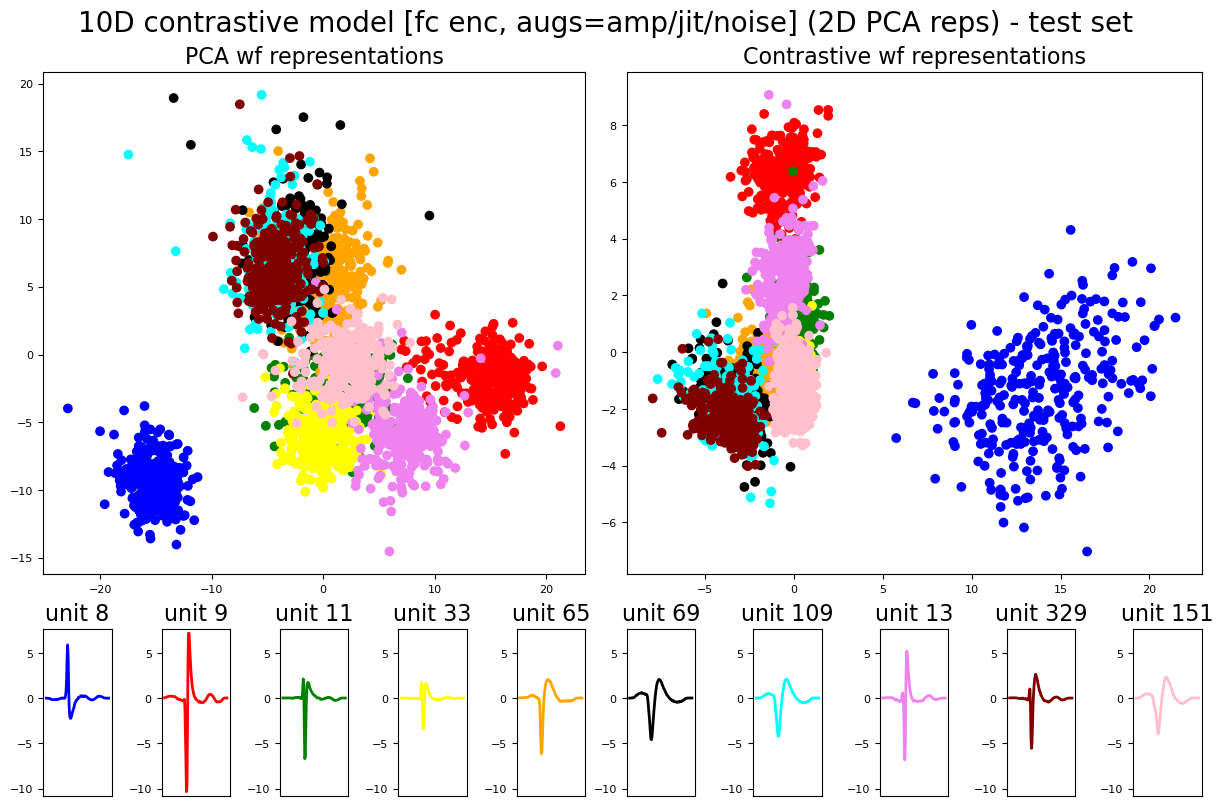

In [185]:
twod_norm_fcenc_path = '/Users/ankit/Documents/PaninskiLab/SimCLR-torch/runs/new_augs/fcenc-2d2d-normal-lr001/checkpoint_0400.pth.tar'
threed_norm_fcenc_path = '/Users/ankit/Documents/PaninskiLab/SimCLR-torch/runs/new_augs/fcenc-3d3d-normal-lr001/checkpoint_0400.pth.tar'
fived_norm_fcenc_path = '/Users/ankit/Documents/PaninskiLab/SimCLR-torch/runs/new_augs/fcenc-5d5d-normal/checkpoint_0500.pth.tar'
tend_norm_fcenc_path = '/Users/ankit/Documents/PaninskiLab/SimCLR-torch/runs/new_augs/fcenc-10d5d-normal-lr001/checkpoint_0400.pth.tar'


contr_reps_train_2d_n, contr_reps_test_2d_n, contr_reps_test_2d_pca_n, pca_train_2d, pca_test_2d = get_ckpt_results(twod_norm_fcenc_path, 2, dy_wfs_interest, dy_wfs_test, True, dy_wfs, wf_interest_dy, '2D contrastive model [fc enc, augs=amp/jit/noise] (2D PCA reps) - test set', enc_type='fc_encoder', Lv=[121, 550, 1100, 250], save_name='pca_v_2dcont_normal_fcenc')
contr_reps_train_3d_n, contr_reps_test_3d_n, contr_reps_test_3d_pca_n, pca_train_3d, pca_test_3d = get_ckpt_results(threed_norm_fcenc_path, 3, dy_wfs_interest, dy_wfs_test, True, dy_wfs, wf_interest_dy, '3D contrastive model [fc enc, augs=amp/jit/noise] (2D PCA reps) - test set', enc_type='fc_encoder', Lv=[121, 550, 1100, 250], save_name='pca_v_3dcont_normal_fcenc')
contr_reps_train_5d_n, contr_reps_test_5d_n, contr_reps_test_5d_pca_n, pca_train_5d, pca_test_5d = get_ckpt_results(fived_norm_fcenc_path, 5, dy_wfs_interest, dy_wfs_test, True, dy_wfs, wf_interest_dy, '5D contrastive model [fc enc, augs=amp/jit/noise] (2D PCA reps) - test set', enc_type='fc_encoder', Lv=[121, 550, 1100, 250], save_name='pca_v_5dcont_normal_fcenc')
contr_reps_train_10d_n, contr_reps_test_10d_n, contr_reps_test_10d_pca_n, pca_train_10d, pca_test_10d = get_ckpt_results(tend_norm_fcenc_path, 10, dy_wfs_interest, dy_wfs_test, True, dy_wfs, wf_interest_dy, '10D contrastive model [fc enc, augs=amp/jit/noise] (2D PCA reps) - test set', enc_type='fc_encoder', Lv=[121, 550, 1100, 250], save_name='pca_v_10dcont_normal_fcenc')


train_reps = [pca_train_2d, pca_train_3d, pca_train_5d, pca_train_10d, 
              contr_reps_train_2d_n, contr_reps_train_3d_n, contr_reps_train_5d_n, 
              contr_reps_train_10d_n]
test_reps = [pca_test_2d, pca_test_3d, pca_test_5d, pca_test_10d,
             contr_reps_test_2d_n, contr_reps_test_3d_n, contr_reps_test_5d_n, 
             contr_reps_test_10d_n]
models = ['PCA 2D', 'PCA 3D', 'PCA 5D', 'PCA 10D',
          'Contrastive 2D (augs=amp/jit/noise, fc encoder)', 'Contrastive 3D (augs=amp/jit/noise, fc encoder)',
          'Contrastive 5D (augs=amp/jit/noise, fc encoder)', 'Contrastive 10D (augs=amp/jit/noise, fc encoder)']


per_class_map = per_class_accs(train_reps, test_reps, models, 10)
avg_class_map = avg_class_accs(train_reps, test_reps, models, 10)

pc_df = pd.DataFrame.from_dict(per_class_map, 'index')
ac_df = pd.DataFrame.from_dict(avg_class_map)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(pc_df)
    
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(ac_df)

In [58]:
train_reps = [pca_train_2d, pca_train_5d, pca_train_10d, pca_train_20d, contr_reps_train_2d, contr_reps_train_5d, contr_reps_train_10d, contr_reps_train_20d]
test_reps = [pca_test_2d, pca_test_5d, pca_test_10d, pca_test_20d, contr_reps_2d, contr_reps_5d, contr_reps_10d, contr_reps_20d]
models = ['PCA 2D', 'PCA 5D', 'PCA 10D', 'PCA 20D', 'Contrastive 2D (lr=0.001)', 'Contrastive 5D (lr=0.001)', 'Contrastive 10D (lr=0.001)', 'Contrastive 20D (lr=0.001)']

per_class_map = per_class_accs(train_reps, test_reps, models, 10)
avg_class_map = avg_class_accs(train_reps, test_reps, models, 10)

Starting epoch 1
Starting epoch 2
Starting epoch 3
Starting epoch 4
Starting epoch 5
Starting epoch 6
Starting epoch 7
Starting epoch 8
Starting epoch 9
Starting epoch 10
Starting epoch 11
Starting epoch 12
Starting epoch 13
Starting epoch 14
Starting epoch 15
Starting epoch 16
Starting epoch 17
Starting epoch 18
Starting epoch 19
Starting epoch 20
Starting epoch 21
Starting epoch 22
Starting epoch 23
Starting epoch 24
Starting epoch 25
Starting epoch 26
Starting epoch 27
Starting epoch 28
Starting epoch 29
Starting epoch 30
Starting epoch 31
Starting epoch 32
Starting epoch 33
Starting epoch 34
Starting epoch 35
Starting epoch 36
Starting epoch 37
Starting epoch 38
Starting epoch 39
Starting epoch 40
Starting epoch 41
Starting epoch 42
Starting epoch 43
Starting epoch 44
Starting epoch 45
Starting epoch 46
Starting epoch 47
Starting epoch 48
Starting epoch 49
Starting epoch 50
Starting epoch 51
Starting epoch 52
Starting epoch 53
Starting epoch 54
Starting epoch 55
Starting epoch 56
S

In [59]:
pc_df = pd.DataFrame.from_dict(per_class_map, 'index')
ac_df = pd.DataFrame.from_dict(avg_class_map)

In [60]:
# pd.set_option('display.max_rows', 10)
# display(pc_df)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(pc_df)

wf 8       wf 9      wf 11      wf 33  \
PCA 2D                      100.000000  98.666667  48.666667  84.333333   
PCA 5D                      100.000000  99.333333  75.000000  92.666667   
PCA 10D                      99.666667  98.666667  82.666667  93.333333   
PCA 20D                     100.000000  95.000000  84.666667  93.000000   
Contrastive 2D (lr=0.001)    97.333333  86.000000  74.666667  62.333333   
Contrastive 5D (lr=0.001)   100.000000  95.666667  90.666667  86.666667   
Contrastive 10D (lr=0.001)  100.000000  94.333333  86.666667  79.666667   
Contrastive 20D (lr=0.001)  100.000000  92.666667  87.000000  82.666667   

                                wf 65      wf 69     wf 109      wf 13  \
PCA 2D                      75.000000  61.000000   0.000000  91.666667   
PCA 5D                      85.333333  42.000000  53.333333  91.000000   
PCA 10D                     90.666667  55.000000  50.666667  94.000000   
PCA 20D                     92.000000  51.333333  46.333333  94.333333   
Contrastive 2D (lr=0.001)   85.333333  43.666667  26.666667  74.666667   
Contrastive 5D (lr=0.001)   88.000000  59.333333  26.333333  78.666667   
Contrastive 10D (lr=0.001)  86.000000  60.000000  25.333333  79.000000   
Contrastive 20D (lr=0.001)  85.666667  44.000000  40.000000  86.000000   

                               wf 329     wf 151  
PCA 2D                      66.000000  70.333333  
PCA 5D                      50.333333  80.000000  
PCA 10D                     57.666667  85.000000  
PCA 20D                     69.000000  86.000000  
Contrastive 2D (lr=0.001)   49.000000  77.666667  
Contrastive 5D (lr=0.001)   69.333333  90.666667  
Contrastive 10D (lr=0.001)  62.666667  87.333333  
Contrastive 20D (lr=0.001)  62.333333  83.333333

In [61]:
# pd.set_option('display.max_rows', 10)
# display(pc_df)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(ac_df)

PCA 2D     PCA 5D    PCA 10D  PCA 20D  Contrastive 2D (lr=0.001)  \
score  69.766667  76.966667  80.566667     81.0                       67.7   

       Contrastive 5D (lr=0.001)  Contrastive 10D (lr=0.001)  \
score                  77.933333                   76.033333   

       Contrastive 20D (lr=0.001)  
score                   76.866667

Using projector; batchnorm False with depth 2
train done
pca test done
300
(3000,)
Using projector; batchnorm False with depth 2
train done
pca test done
300
(3000,)
Using projector; batchnorm False with depth 2
train done
pca test done
300
(3000,)
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.


wf 8       wf 9      wf 11      wf 33  \
PCA 10D                     100.000000  97.333333  78.666667  93.000000   
PCA 20D                      99.666667  96.333333  85.333333  92.000000   
Contrastive 10D (lr=0.001)  100.000000  93.000000  89.666667  83.333333   
Contrastive 10D (lr=0.005)  100.000000  92.000000  86.666667  82.333333   
Contrastive 20D (lr=0.001)   99.666667  94.333333  90.333333  87.000000   

                                wf 65      wf 69     wf 109      wf 13  \
PCA 10D                     86.333333  58.000000  32.666667  94.666667   
PCA 20D                     90.333333  52.666667  58.666667  92.333333   
Contrastive 10D (lr=0.001)  89.333333  51.666667  29.000000  85.333333   
Contrastive 10D (lr=0.005)  78.666667  54.333333  23.000000  84.000000   
Contrastive 20D (lr=0.001)  85.666667  53.333333  41.666667  89.333333   

                               wf 329     wf 151  
PCA 10D                     69.333333  87.666667  
PCA 20D                     58.000000  83.333333  
Contrastive 10D (lr=0.001)  65.333333  88.000000  
Contrastive 10D (lr=0.005)  65.333333  82.333333  
Contrastive 20D (lr=0.001)  58.000000  86.333333

PCA 10D    PCA 20D  Contrastive 10D (lr=0.001)  \
score     80.7  80.766667                        77.1   

       Contrastive 10D (lr=0.005)  Contrastive 20D (lr=0.001)  
score                   74.433333                        78.4

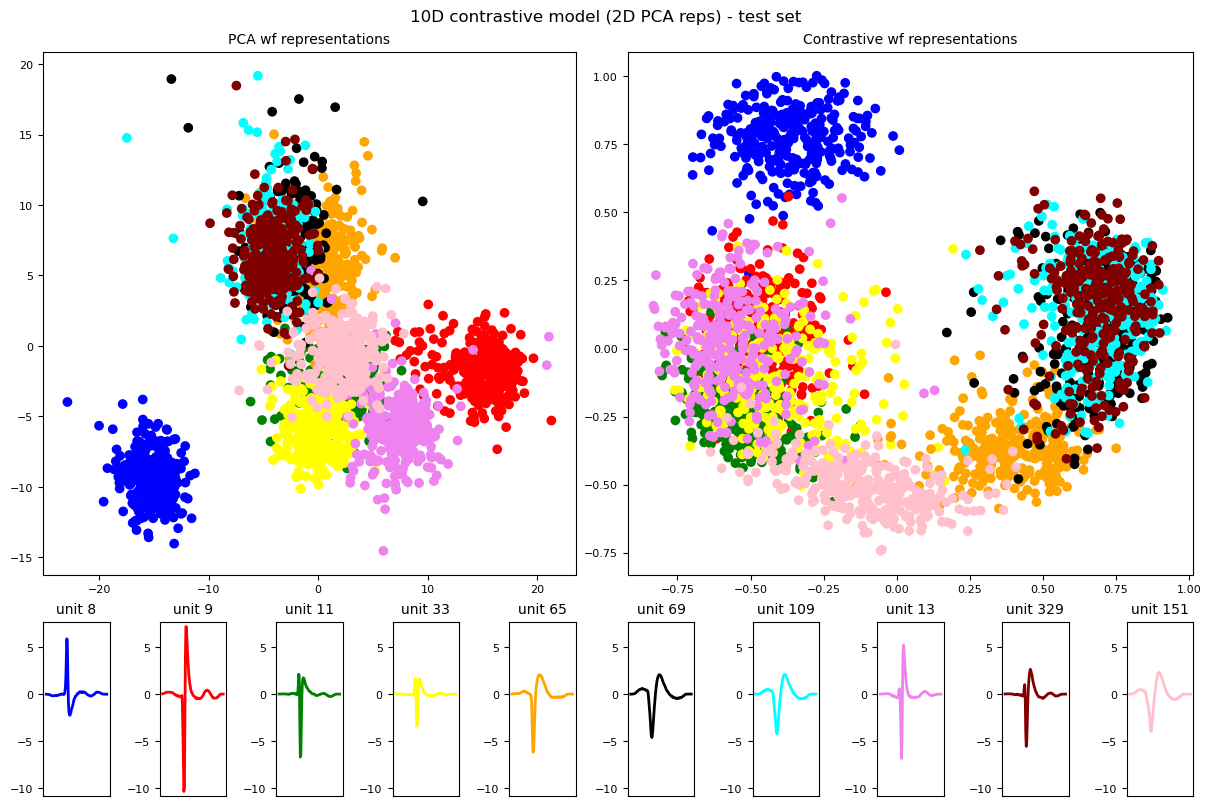

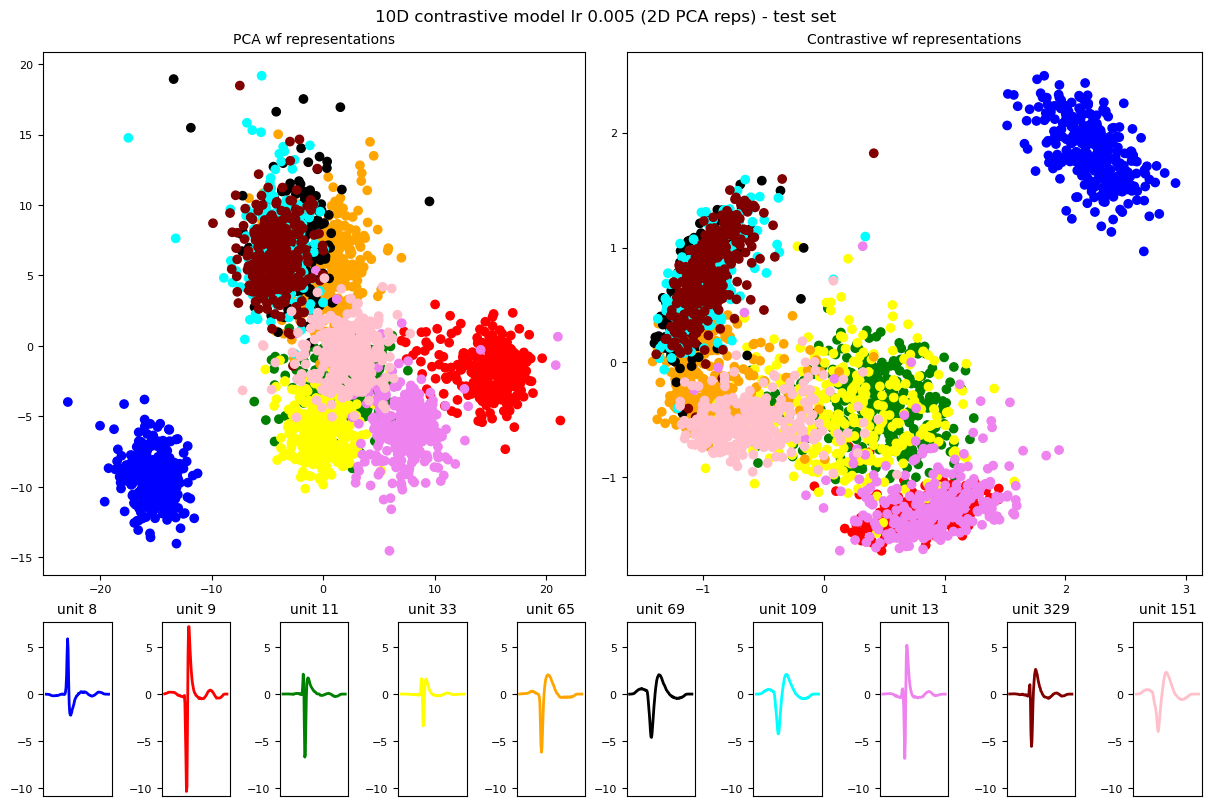

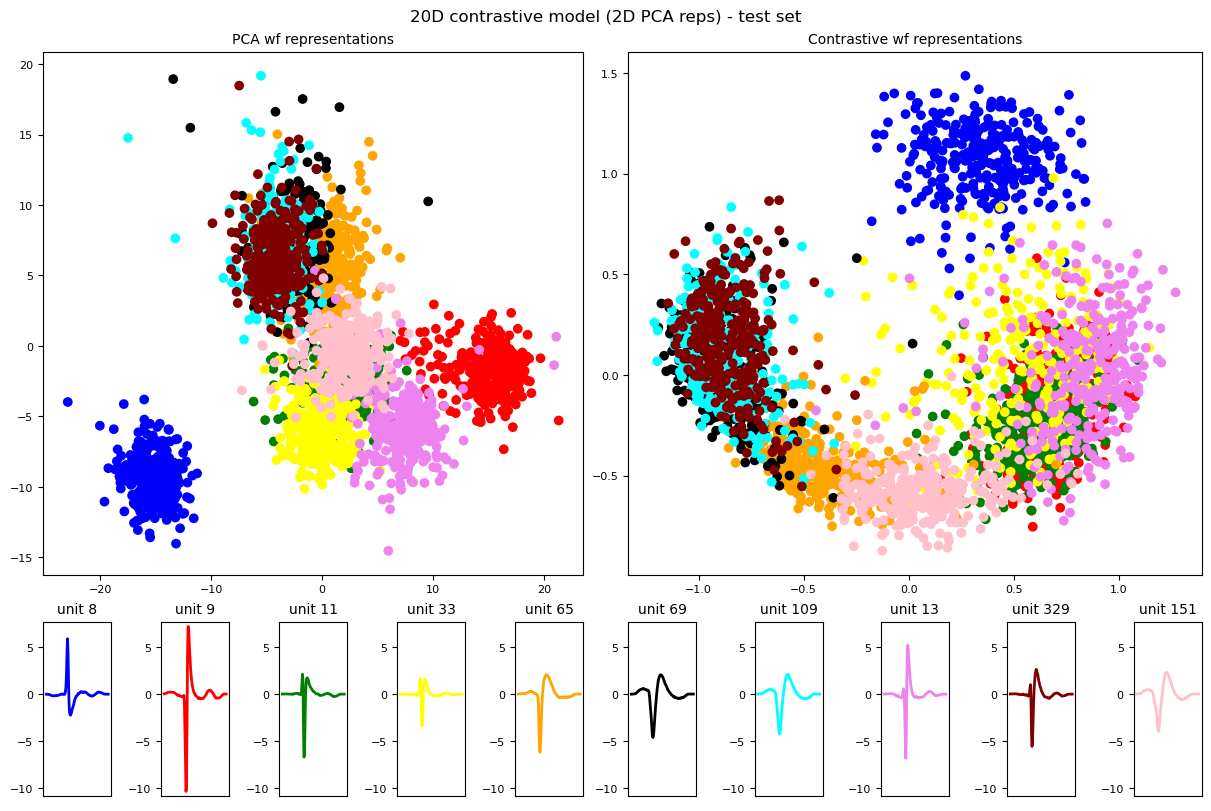

In [98]:
tend_enc_path = '/Users/ankit/Documents/PaninskiLab/SimCLR-torch/runs/proj_dim_5/enc-10d-pd-lr001/checkpoint_1000.pth.tar'
twentyd_enc_path = '/Users/ankit/Documents/PaninskiLab/SimCLR-torch/runs/proj_dim_5/enc-20d-pd-lr001/checkpoint_1000.pth.tar'
tend_lr_enc_path = '/Users/ankit/Documents/PaninskiLab/SimCLR-torch/runs/proj_dim_5/enc-10d-pd-lr005/checkpoint_1000.pth.tar'

contr_reps_train_10d, contr_reps_test_10d, contr_reps_test_10d_pca, pca_train_10d, pca_test_10d = get_ckpt_results(tend_enc_path, 10, dy_wfs_interest, dy_wfs_test, True, dy_wfs, wf_interest_dy, '10D contrastive model (2D PCA reps) - test set', save_name='pca_v_10dcont_pjlr001_sdv4')
contr_reps_train_10d_lr, contr_reps_test_10d_lr, contr_reps_test_10d_lr_pca, _, _ = get_ckpt_results(tend_lr_enc_path, 10, dy_wfs_interest, dy_wfs_test, True, dy_wfs, wf_interest_dy, '10D contrastive model lr 0.005 (2D PCA reps) - test set', save_name='pca_v_10dcont_pjlr005_sdv4')
contr_reps_train_20d, contr_reps_test_20d, contr_reps_test_20d_pca, pca_train_20d, pca_test_20d = get_ckpt_results(twentyd_enc_path, 20, dy_wfs_interest, dy_wfs_test, True, dy_wfs, wf_interest_dy, '20D contrastive model (2D PCA reps) - test set', save_name='pca_v_20dcont_pjlr001_sdv4')

train_reps = [pca_train_10d, pca_train_20d, contr_reps_train_10d, contr_reps_train_10d_lr, contr_reps_train_20d]
test_reps = [pca_test_10d, pca_test_20d, contr_reps_test_10d, contr_reps_test_10d_lr, contr_reps_test_20d]
models = ['PCA 10D', 'PCA 20D', 'Contrastive 10D (lr=0.001)', 'Contrastive 10D (lr=0.005)', 'Contrastive 20D (lr=0.001)']

per_class_map = per_class_accs(train_reps, test_reps, models, 10)
avg_class_map = avg_class_accs(train_reps, test_reps, models, 10)

pc_df = pd.DataFrame.from_dict(per_class_map, 'index')
ac_df = pd.DataFrame.from_dict(avg_class_map)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(pc_df)
    
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(ac_df)

Using projector; batchnorm False with depth 2
train done
pca test done
300
(3000,)
Using projector; batchnorm False with depth 2
train done
pca test done
300
(3000,)
Using projector; batchnorm False with depth 2
train done
pca test done
300
(3000,)
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.


wf 8       wf 9  \
PCA 10D                                         100.000000  99.000000   
PCA 20D                                         100.000000  96.333333   
Contrastive 10D (lr=0.001)                      100.000000  92.666667   
Contrastive 10D (lr=0.001, noise/collision on)  100.000000  96.666667   
Contrastive 20D (lr=0.001)                       99.666667  95.666667   

                                                    wf 11      wf 33  \
PCA 10D                                         80.333333  92.333333   
PCA 20D                                         82.000000  92.333333   
Contrastive 10D (lr=0.001)                      89.000000  84.000000   
Contrastive 10D (lr=0.001, noise/collision on)  89.666667  81.333333   
Contrastive 20D (lr=0.001)                      90.333333  84.000000   

                                                    wf 65      wf 69  \
PCA 10D                                         87.333333  53.000000   
PCA 20D                                         87.666667  39.333333   
Contrastive 10D (lr=0.001)                      89.333333  57.000000   
Contrastive 10D (lr=0.001, noise/collision on)  83.333333  27.000000   
Contrastive 20D (lr=0.001)                      85.333333  51.333333   

                                                   wf 109      wf 13  \
PCA 10D                                         52.000000  94.666667   
PCA 20D                                         51.666667  93.000000   
Contrastive 10D (lr=0.001)                      30.666667  85.000000   
Contrastive 10D (lr=0.001, noise/collision on)  48.000000  89.333333   
Contrastive 20D (lr=0.001)                      37.666667  88.000000   

                                                   wf 329     wf 151  
PCA 10D                                         62.000000  87.333333  
PCA 20D                                         54.666667  85.666667  
Contrastive 10D (lr=0.001)                      57.333333  87.666667  
Contrastive 10D (lr=0.001, noise/collision on)  69.333333  88.333333  
Contrastive 20D (lr=0.001)                      65.333333  90.666667

PCA 10D    PCA 20D  Contrastive 10D (lr=0.001)  \
score  80.133333  77.733333                   77.366667   

       Contrastive 10D (lr=0.001, noise/collision on)  \
score                                       77.133333   

       Contrastive 20D (lr=0.001)  
score                   78.766667

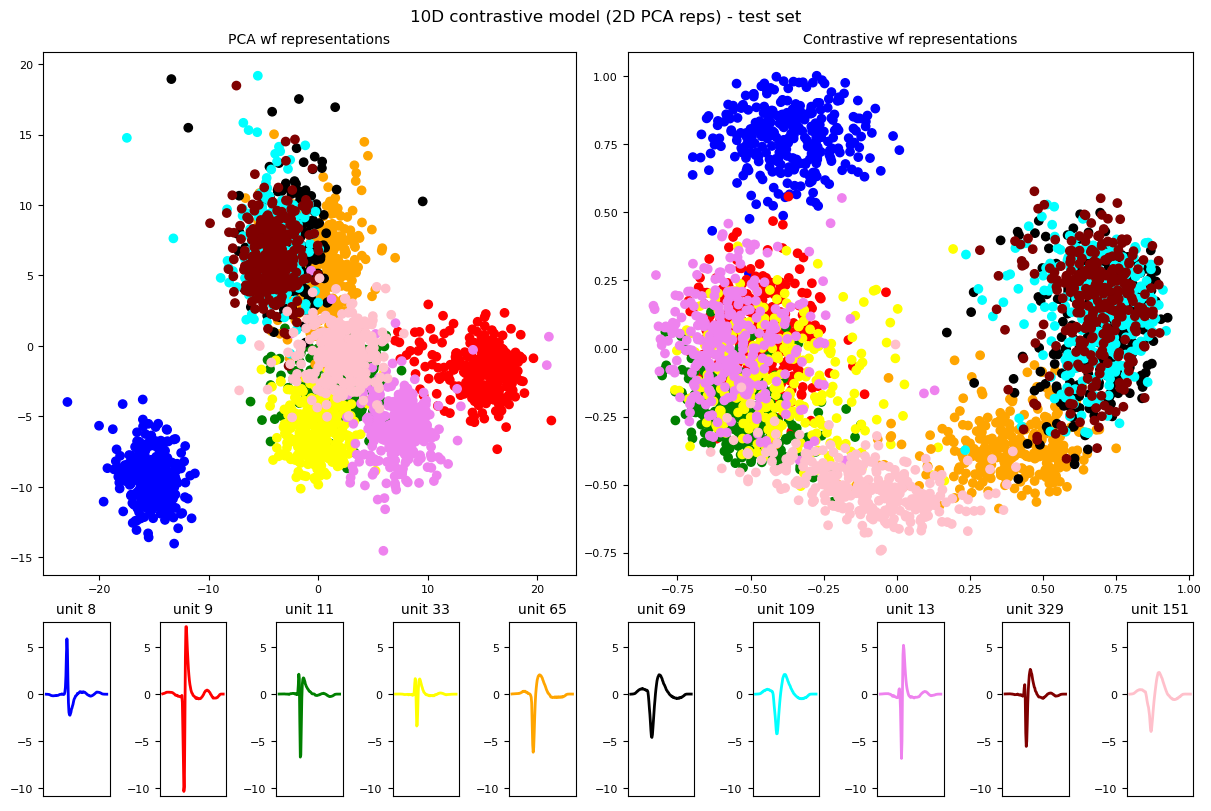

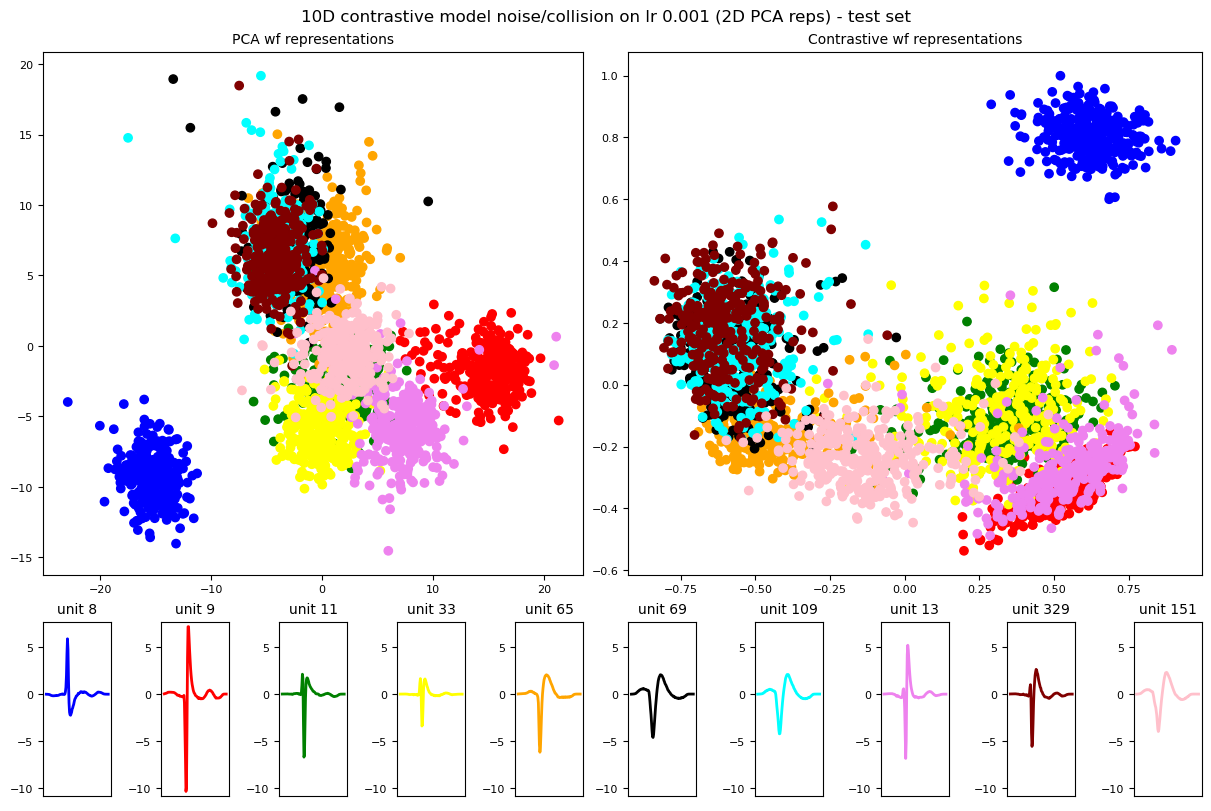

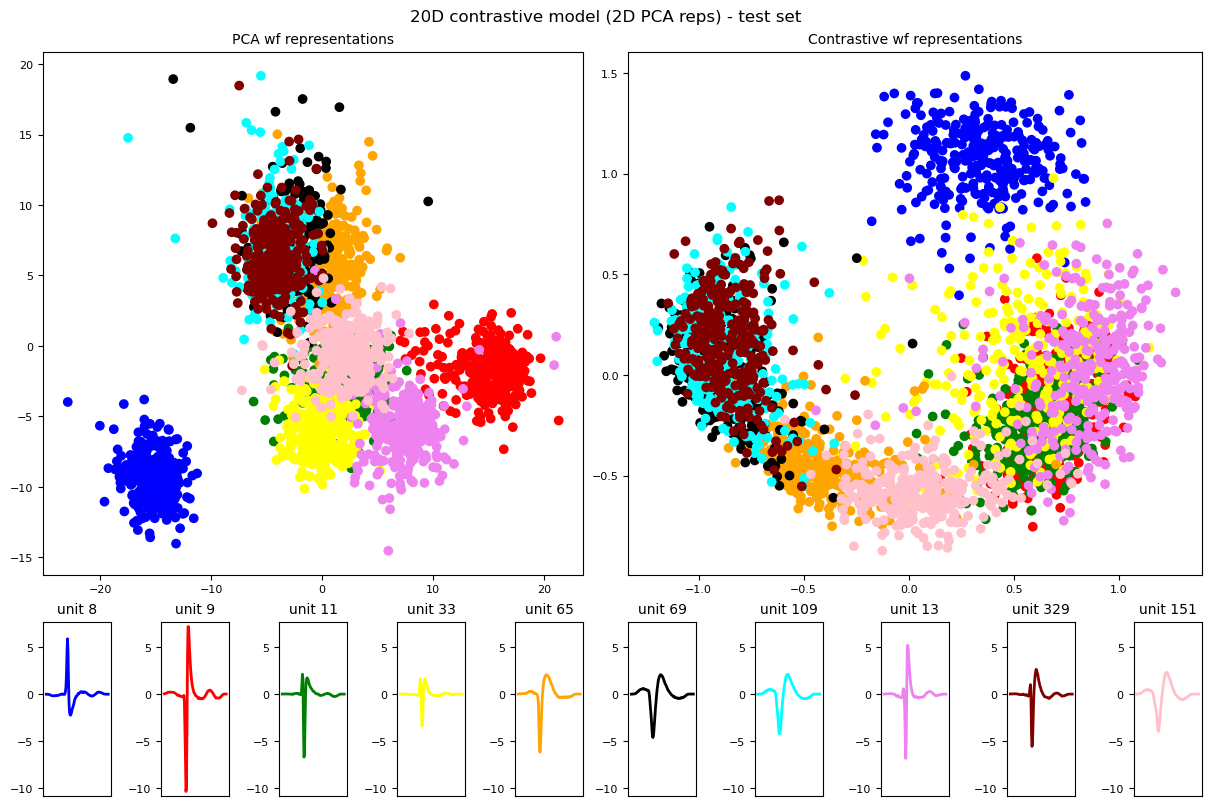

In [51]:
tend_enc_path = '/Users/ankit/Documents/PaninskiLab/SimCLR-torch/runs/proj_dim_5/enc-10d-pd-lr001/checkpoint_1000.pth.tar'
twentyd_enc_path = '/Users/ankit/Documents/PaninskiLab/SimCLR-torch/runs/proj_dim_5/enc-20d-pd-lr001/checkpoint_1000.pth.tar'
tend_na_enc_path = '/Users/ankit/Documents/PaninskiLab/SimCLR-torch/runs/new_augs/enc-10d-lr001/checkpoint_1000.pth.tar'

contr_reps_train_10d, contr_reps_test_10d, contr_reps_test_10d_pca, pca_train_10d, pca_test_10d = get_ckpt_results(tend_enc_path, 10, dy_wfs_interest, dy_wfs_test, True, dy_wfs, wf_interest_dy, '10D contrastive model (2D PCA reps) - test set', save_name='pca_v_10dcont_pjlr001_sdv4')
contr_reps_train_10d_na, contr_reps_test_10d_na, contr_reps_test_10d_na_pca, _, _ = get_ckpt_results(tend_na_enc_path, 10, dy_wfs_interest, dy_wfs_test, True, dy_wfs, wf_interest_dy, '10D contrastive model noise/collision on lr 0.001 (2D PCA reps) - test set', save_name='pca_v_10dcont_pjlr005_ua_sdv4')
contr_reps_train_20d, contr_reps_test_20d, contr_reps_test_20d_pca, pca_train_20d, pca_test_20d = get_ckpt_results(twentyd_enc_path, 20, dy_wfs_interest, dy_wfs_test, True, dy_wfs, wf_interest_dy, '20D contrastive model (2D PCA reps) - test set', save_name='pca_v_20dcont_pjlr001_sdv4')

train_reps = [pca_train_10d, pca_train_20d, contr_reps_train_10d, contr_reps_train_10d_na, contr_reps_train_20d]
test_reps = [pca_test_10d, pca_test_20d, contr_reps_test_10d, contr_reps_test_10d_na, contr_reps_test_20d]
models = ['PCA 10D', 'PCA 20D', 'Contrastive 10D (lr=0.001)', 'Contrastive 10D (lr=0.001, noise/collision on)', 'Contrastive 20D (lr=0.001)']

per_class_map = per_class_accs(train_reps, test_reps, models, 10)
avg_class_map = avg_class_accs(train_reps, test_reps, models, 10)

pc_df = pd.DataFrame.from_dict(per_class_map, 'index')
ac_df = pd.DataFrame.from_dict(avg_class_map)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(pc_df)
    
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(ac_df)